## 1. Import Libraries

In [118]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    OrdinalEncoder,
    MinMaxScaler,
    PowerTransformer,
    FunctionTransformer
) 

from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
)
from feature_engine.datetime import DatetimeFeatures
from feature_engine.outliers import Winsorizer
from feature_engine.selection import SelectBySingleFeaturePerformance

import matplotlib.pyplot as plt

import warnings

## 2. Display Settings

In [54]:
pd.set_option("display.max_columns",None)

In [55]:
sklearn.set_config(transform_output="pandas")

In [56]:
warnings.filterwarnings("ignore")

## 3. Read the Data

In [57]:
file_path = r"C:\Users\vaibh\OneDrive\Desktop\Flight_Sagemaker_Project\data\train.csv"
train = pd.read_csv(file_path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Goair,2019-06-24,Delhi,Cochin,14:25:00,19:35:00,310,1.0,No Info,7870
1,Indigo,2019-04-03,Mumbai,Hyderabad,16:55:00,18:25:00,90,0.0,No Info,3175
2,Indigo,2019-03-06,Delhi,Cochin,04:45:00,13:20:00,515,1.0,No Info,13611
3,Air India,2019-06-15,Banglore,Delhi,10:00:00,12:45:00,165,0.0,No Info,6961
4,Jet Airways,2019-04-06,Banglore,Delhi,08:20:00,11:20:00,180,0.0,No Info,7229
...,...,...,...,...,...,...,...,...,...,...
635,Multiple Carriers,2019-06-15,Delhi,Cochin,06:00:00,19:00:00,780,1.0,No Info,11789
636,Spicejet,2019-03-12,Kolkata,Banglore,09:00:00,11:30:00,150,0.0,No Info,6982
637,Air India,2019-03-21,Banglore,New Delhi,08:15:00,23:10:00,895,1.0,No Info,4943
638,Jet Airways,2019-04-27,Banglore,Delhi,07:10:00,10:10:00,180,0.0,No Info,7229


In [58]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [59]:
x_train = train.drop(columns="price")
y_train = train.price.copy()

## 4. Transformation Operations

### 4.1 airline

In [60]:
x_train.airline

0                  Goair
1                 Indigo
2                 Indigo
3              Air India
4            Jet Airways
             ...        
635    Multiple Carriers
636             Spicejet
637            Air India
638          Jet Airways
639          Jet Airways
Name: airline, Length: 640, dtype: object

In [61]:
air_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("grouper", RareLabelEncoder(tol=0.1,replace_with="other",n_categories=2)),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(x_train.loc[:,["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_other
0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
635,0.0,0.0,0.0,1.0,0.0
636,0.0,0.0,0.0,0.0,1.0
637,1.0,0.0,0.0,0.0,0.0
638,0.0,0.0,1.0,0.0,0.0


### 4.2 date_of_journey

In [62]:
x_train.date_of_journey

0      2019-06-24
1      2019-04-03
2      2019-03-06
3      2019-06-15
4      2019-04-06
          ...    
635    2019-06-15
636    2019-03-12
637    2019-03-21
638    2019-04-27
639    2019-05-18
Name: date_of_journey, Length: 640, dtype: object

In [63]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
	("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(x_train.loc[:, ["date_of_journey"]])


,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,1.000000,1.000000,0.000000,0.974576
1,0.333333,0.294118,0.333333,0.279661
2,0.000000,0.058824,0.333333,0.042373
3,1.000000,0.882353,0.833333,0.898305
4,0.333333,0.294118,0.833333,0.305085
...,...,...,...,...
635,1.000000,0.882353,0.833333,0.898305
636,0.000000,0.117647,0.166667,0.093220
637,0.000000,0.176471,0.500000,0.169492
638,0.333333,0.470588,0.833333,0.483051


### 4.3 source & destination

In [64]:
x_train.source

0         Delhi
1        Mumbai
2         Delhi
3      Banglore
4      Banglore
         ...   
635       Delhi
636     Kolkata
637    Banglore
638    Banglore
639       Delhi
Name: source, Length: 640, dtype: object

In [65]:
x_train.destination

0         Cochin
1      Hyderabad
2         Cochin
3          Delhi
4          Delhi
         ...    
635       Cochin
636     Banglore
637    New Delhi
638        Delhi
639       Cochin
Name: destination, Length: 640, dtype: object

In [66]:
location_subset = x_train.loc[:,["source","destination"]]
location_subset

,source,destination
0,Delhi,Cochin
1,Mumbai,Hyderabad
2,Delhi,Cochin
3,Banglore,Delhi
4,Banglore,Delhi
...,...,...
635,Delhi,Cochin
636,Kolkata,Banglore
637,Banglore,New Delhi
638,Banglore,Delhi


In [67]:
location_pipe1 = Pipeline(steps=[
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="other", n_categories=2)),
    ("encoder",MeanEncoder()),
    ("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset,y_train)

,source,destination
0,1.035284,1.057947
1,-1.992325,-0.760650
2,1.035284,1.057947
3,-0.464518,-1.931167
4,-0.464518,-1.931167
...,...,...
635,1.035284,1.057947
636,-0.424387,-0.332179
637,-0.464518,-0.760650
638,-0.464518,-1.931167


In [68]:
np.union1d(
    x_train.source.unique(),
    x_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [69]:
def is_north(x):
    columns = x.columns.to_list()
    north_cities = ["Delhi","Kolkata","Mumbai","New Delhi"]
    return(
        x
        .assign(**{
            f"{col}_is_north": x.loc[:,col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )
FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,0,1
4,0,1
...,...,...
635,1,0
636,1,0
637,0,1
638,0,1


In [70]:
location_transformer = FeatureUnion(transformer_list=[
    ("part1", location_pipe1),
    ("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset,y_train)

,source,destination,source_is_north,destination_is_north
0,1.035284,1.057947,1,0
1,-1.992325,-0.760650,1,0
2,1.035284,1.057947,1,0
3,-0.464518,-1.931167,0,1
4,-0.464518,-1.931167,0,1
...,...,...,...,...
635,1.035284,1.057947,1,0
636,-0.424387,-0.332179,1,0
637,-0.464518,-0.760650,0,1
638,-0.464518,-1.931167,0,1


### 4.4 dep_time & arrival_time

In [71]:
x_train.dep_time

0      14:25:00
1      16:55:00
2      04:45:00
3      10:00:00
4      08:20:00
         ...   
635    06:00:00
636    09:00:00
637    08:15:00
638    07:10:00
639    20:00:00
Name: dep_time, Length: 640, dtype: object

In [72]:
x_train.arrival_time

0      19:35:00
1      18:25:00
2      13:20:00
3      12:45:00
4      11:20:00
         ...   
635    19:00:00
636    11:30:00
637    23:10:00
638    10:10:00
639    04:25:00
Name: arrival_time, Length: 640, dtype: object

In [73]:
time_subset = x_train.loc[:,["dep_time","arrival_time"]]
time_subset

,dep_time,arrival_time
0,14:25:00,19:35:00
1,16:55:00,18:25:00
2,04:45:00,13:20:00
3,10:00:00,12:45:00
4,08:20:00,11:20:00
...,...,...
635,06:00:00,19:00:00
636,09:00:00,11:30:00
637,08:15:00,23:10:00
638,07:10:00,10:10:00


In [74]:
time_pipe1 = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=["hour","minute"])),
    ("scaler", MinMaxScaler())
])
time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.608696,0.454545,0.826087,0.636364
1,0.695652,1.000000,0.782609,0.454545
2,0.173913,0.818182,0.565217,0.363636
3,0.434783,0.000000,0.521739,0.818182
4,0.347826,0.363636,0.478261,0.363636
...,...,...,...,...
635,0.260870,0.000000,0.826087,0.000000
636,0.391304,0.000000,0.478261,0.545455
637,0.347826,0.272727,1.000000,0.181818
638,0.304348,0.181818,0.434783,0.181818


In [75]:
def part_of_day(x, morning=4, noon=12, eve=16, night=20):
	columns = x.columns.to_list()
	x_temp = x.assign(**{
		col: pd.to_datetime(x.loc[:, col]).dt.hour
		for col in columns
	})

	return (
		x_temp
		.assign(**{
			f"{col}_part_of_day": np.select(
				[x_temp.loc[:, col].between(morning, noon, inclusive="left"),
				 x_temp.loc[:, col].between(noon, eve, inclusive="left"),
				 x_temp.loc[:, col].between(eve, night, inclusive="left")],
				["morning", "afternoon", "evening"],
				default="night"
			)
			for col in columns
		})
		.drop(columns=columns)
	)

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,afternoon,evening
1,evening,evening
2,morning,afternoon
3,morning,afternoon
4,morning,morning
...,...,...
635,morning,evening
636,morning,morning
637,morning,night
638,morning,morning


In [76]:
time_pipe2 = Pipeline(steps=[
	("part", FunctionTransformer(func=part_of_day)),
	("encoder", CountFrequencyEncoder()),
	("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,0.000000,0.483516
1,0.153191,0.483516
2,1.000000,0.000000
3,1.000000,0.000000
4,1.000000,1.000000
...,...,...
635,1.000000,0.483516
636,1.000000,1.000000
637,1.000000,0.934066
638,1.000000,1.000000


In [77]:
time_transformer = FeatureUnion(transformer_list=[
	("part1", time_pipe1),
	("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.608696,0.454545,0.826087,0.636364,0.000000,0.483516
1,0.695652,1.000000,0.782609,0.454545,0.153191,0.483516
2,0.173913,0.818182,0.565217,0.363636,1.000000,0.000000
3,0.434783,0.000000,0.521739,0.818182,1.000000,0.000000
4,0.347826,0.363636,0.478261,0.363636,1.000000,1.000000
...,...,...,...,...,...,...
635,0.260870,0.000000,0.826087,0.000000,1.000000,0.483516
636,0.391304,0.000000,0.478261,0.545455,1.000000,1.000000
637,0.347826,0.272727,1.000000,0.181818,1.000000,0.934066
638,0.304348,0.181818,0.434783,0.181818,1.000000,1.000000


### 4.5 duration

In [78]:
x_train.duration

0      310
1       90
2      515
3      165
4      180
      ... 
635    780
636    150
637    895
638    180
639    505
Name: duration, Length: 640, dtype: int64

In [85]:
(
	x_train
	.duration
	.quantile([0.25, 0.5, 0.75])
	.values
	.reshape(-1, 1)
	# .shape
)

array([[170.  ],
       [485.  ],
       [861.25]])

In [84]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, x, y=None):
		if not self.variables:
			self.variables = x.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				x
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, x):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(x.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

In [86]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(x_train)


,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,6.293989e-54,0.000000e+00,1.000000,1.000000
1,0.000000e+00,0.000000e+00,0.904837,0.904837
2,0.000000e+00,0.000000e+00,1.000000,1.000000
3,0.000000e+00,0.000000e+00,0.904837,0.904837
4,0.000000e+00,0.000000e+00,0.904837,0.904837
...,...,...,...,...
635,0.000000e+00,0.000000e+00,1.000000,1.000000
636,0.000000e+00,0.000000e+00,0.904837,0.904837
637,0.000000e+00,1.569292e-213,1.000000,1.000000
638,0.000000e+00,0.000000e+00,0.904837,0.904837


In [90]:
def duration_category(x, short=180, med=400):
	return (
		x
		.assign(duration_cat=np.select([x.duration.lt(short),
									    x.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [91]:
def is_over(x, value=1000):
	return (
		x
		.assign(**{
			f"duration_over_{value}": x.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [97]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(x_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.332710,-0.138852,-0.09917,1.0,0,-0.621725
1,-0.332710,-0.138852,-0.09917,0.0,0,-1.084446
2,-0.332710,-0.138852,-0.09917,2.0,0,-0.190554
3,2.816343,-0.138852,-0.09917,0.0,0,-0.926701
4,-0.328411,-0.138852,-0.09917,1.0,0,-0.895151
...,...,...,...,...,...,...
635,-0.332710,-0.138852,-0.09917,2.0,0,0.366814
636,-0.332710,-0.138852,-0.09917,0.0,0,-0.958250
637,-0.332710,-0.138852,-0.09917,2.0,0,0.608691
638,-0.328411,-0.138852,-0.09917,1.0,0,-0.895151


### 4.6 total_stops

In [99]:
x_train.total_stops


0      1.0
1      0.0
2      1.0
3      0.0
4      0.0
      ... 
635    1.0
636    0.0
637    1.0
638    0.0
639    2.0
Name: total_stops, Length: 640, dtype: float64

In [100]:
def is_direct(x):
	return x.assign(is_direct_flight=x.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(x_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,0.0,1
2,1.0,0
3,0.0,1
4,0.0,1
...,...,...
635,1.0,0
636,0.0,1
637,1.0,0
638,0.0,1


### 4.7 additional_info

In [101]:
x_train.additional_info


0                          No Info
1                          No Info
2                          No Info
3                          No Info
4                          No Info
                  ...             
635                        No Info
636                        No Info
637                        No Info
638                        No Info
639    In-flight meal not included
Name: additional_info, Length: 640, dtype: object

In [102]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(x_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
635,0.0,1.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,0.0,1.0,0.0


In [103]:
def have_info(x):
	return x.assign(additional_info=x.additional_info.ne("No Info").astype(int))

In [104]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [105]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(x_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
635,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


## 5. Column Transformer

In [106]:
column_transformer = ColumnTransformer(transformers=[
	("air", air_transformer, ["airline"]),
	("doj", doj_transformer, ["date_of_journey"]),
	("location", location_transformer, ["source", 'destination']),
	("time", time_transformer, ["dep_time", "arrival_time"]),
	("dur", duration_transformer, ["duration"]),
	("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(x_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,0.0,0.0,0.0,1.0,1.000000,1.000000,0.000000,0.974576,1.035284,1.057947,1,0,0.608696,0.454545,0.826087,0.636364,0.000000,0.483516,-0.332710,-0.138852,-0.09917,1.0,0,-0.621725,1.0,0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0.0,0.0,0.333333,0.294118,0.333333,0.279661,-1.992325,-0.760650,1,0,0.695652,1.000000,0.782609,0.454545,0.153191,0.483516,-0.332710,-0.138852,-0.09917,0.0,0,-1.084446,0.0,1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0.0,0.0,0.000000,0.058824,0.333333,0.042373,1.035284,1.057947,1,0,0.173913,0.818182,0.565217,0.363636,1.000000,0.000000,-0.332710,-0.138852,-0.09917,2.0,0,-0.190554,1.0,0,0.0,1.0,0.0,0
3,1.0,0.0,0.0,0.0,0.0,1.000000,0.882353,0.833333,0.898305,-0.464518,-1.931167,0,1,0.434783,0.000000,0.521739,0.818182,1.000000,0.000000,2.816343,-0.138852,-0.09917,0.0,0,-0.926701,0.0,1,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.333333,0.294118,0.833333,0.305085,-0.464518,-1.931167,0,1,0.347826,0.363636,0.478261,0.363636,1.000000,1.000000,-0.328411,-0.138852,-0.09917,1.0,0,-0.895151,0.0,1,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,0.0,1.0,0.0,1.000000,0.882353,0.833333,0.898305,1.035284,1.057947,1,0,0.260870,0.000000,0.826087,0.000000,1.000000,0.483516,-0.332710,-0.138852,-0.09917,2.0,0,0.366814,1.0,0,0.0,1.0,0.0,0
636,0.0,0.0,0.0,0.0,1.0,0.000000,0.117647,0.166667,0.093220,-0.424387,-0.332179,1,0,0.391304,0.000000,0.478261,0.545455,1.000000,1.000000,-0.332710,-0.138852,-0.09917,0.0,0,-0.958250,0.0,1,0.0,1.0,0.0,0
637,1.0,0.0,0.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,-0.464518,-0.760650,0,1,0.347826,0.272727,1.000000,0.181818,1.000000,0.934066,-0.332710,-0.138852,-0.09917,2.0,0,0.608691,1.0,0,0.0,1.0,0.0,0
638,0.0,0.0,1.0,0.0,0.0,0.333333,0.470588,0.833333,0.483051,-0.464518,-1.931167,0,1,0.304348,0.181818,0.434783,0.181818,1.000000,1.000000,-0.328411,-0.138852,-0.09917,1.0,0,-0.895151,0.0,1,0.0,1.0,0.0,0


## 5. Feature Selection

In [112]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

## 6. Putting it all Together

In [113]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(x_train, y_train)

,air__airline_Jet Airways,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,dur__duration_cat,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,1.000000,0.974576,1.035284,1.0,-0.621725,1.0,0
1,0.0,0.294118,0.279661,-1.992325,0.0,-1.084446,0.0,1
2,0.0,0.058824,0.042373,1.035284,2.0,-0.190554,1.0,0
3,0.0,0.882353,0.898305,-0.464518,0.0,-0.926701,0.0,1
4,1.0,0.294118,0.305085,-0.464518,1.0,-0.895151,0.0,1
...,...,...,...,...,...,...,...,...
635,0.0,0.882353,0.898305,1.035284,2.0,0.366814,1.0,0
636,0.0,0.117647,0.093220,-0.424387,0.0,-0.958250,0.0,1
637,0.0,0.176471,0.169492,-0.464518,2.0,0.608691,1.0,0
638,1.0,0.470588,0.483051,-0.464518,1.0,-0.895151,0.0,1


## 7. Visualizations

In [114]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': -0.01948412851829817,
 'air__airline_Indigo': 0.09209636887940924,
 'air__airline_Jet Airways': 0.11422828498877007,
 'air__airline_Multiple Carriers': 0.011520307170818237,
 'air__airline_other': 0.08653655980071924,
 'doj__date_of_journey_month': 0.07189591871867995,
 'doj__date_of_journey_week': 0.1897287864676316,
 'doj__date_of_journey_day_of_week': -0.01573887582506306,
 'doj__date_of_journey_day_of_year': 0.22675515357256626,
 'location__source': 0.10844221660920043,
 'location__destination': 0.0876655311370373,
 'location__source_is_north': -0.011051430586791144,
 'location__destination_is_north': -0.011051430586791144,
 'time__dep_time_hour': -0.01936438770108036,
 'time__dep_time_minute': 0.013857103267090701,
 'time__arrival_time_hour': -0.005262644028364442,
 'time__arrival_time_minute': -0.022247647758559808,
 'time__dep_time_part_of_day': -0.020172282932795715,
 'time__arrival_time_part_of_day': -0.01516347344156499,
 'dur__duration_rbf_25': 0.0

In [116]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'info__additional_info_No Info': -0.022678745753489233,
 'info__additional_info': -0.022678745753489233,
 'info__additional_info_In-flight meal not included': -0.022560104847462552,
 'time__arrival_time_minute': -0.022247647758559808,
 'time__dep_time_part_of_day': -0.020172282932795715,
 'air__airline_Air India': -0.01948412851829817,
 'dur__duration_rbf_50': -0.019381408577395936,
 'time__dep_time_hour': -0.01936438770108036,
 'dur__duration_rbf_75': -0.019192739671263965,
 'doj__date_of_journey_day_of_week': -0.01573887582506306,
 'time__arrival_time_part_of_day': -0.01516347344156499,
 'location__source_is_north': -0.011051430586791144,
 'location__destination_is_north': -0.011051430586791144,
 'time__arrival_time_hour': -0.005262644028364442,
 'info__additional_info_Other': -0.00501702925354582,
 'air__airline_Multiple Carriers': 0.011520307170818237,
 'time__dep_time_minute': 0.013857103267090701,
 'dur__duration_rbf_25': 0.05589388699011825,
 'dur__duration_over_1000': 0.059652

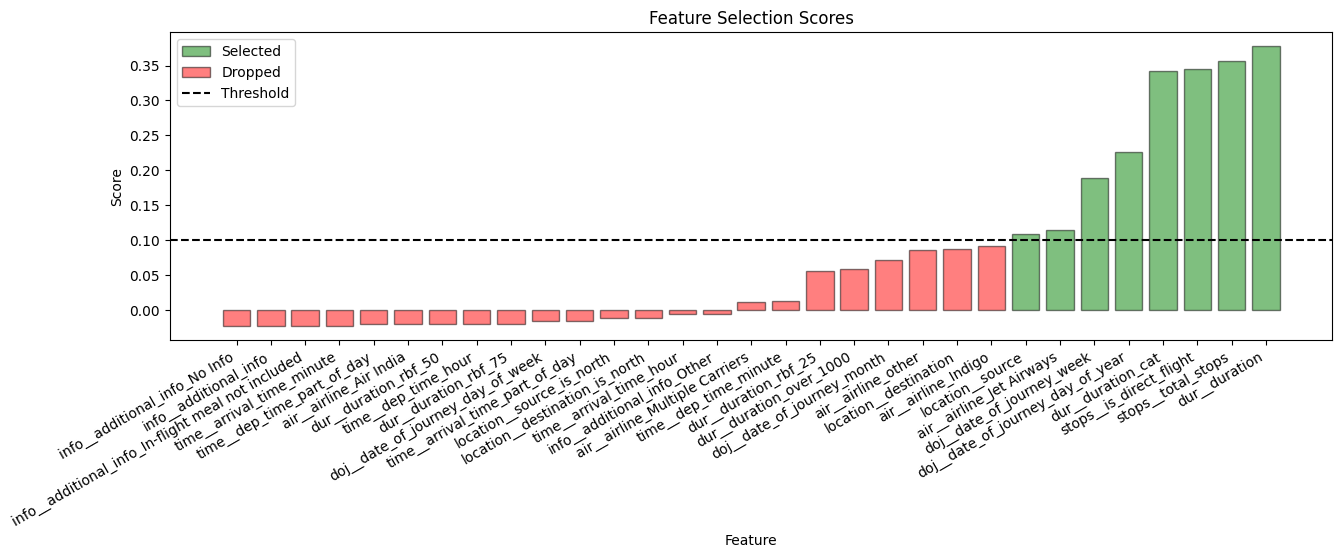

In [119]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()